In [ ]:
# Imports
import os
import time
from datetime import datetime
import tqdm

import numpy as np
import pandas as pd
import scipy.io
import scipy
from scipy.ndimage import gaussian_filter

import copy
import tarfile

import matplotlib.pyplot as plt

In [ ]:
# Torch imports
import torch
import torchvision

from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import AlexNet_Weights
import torchvision.transforms as transforms
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter # TODO: Ta Bort?

In [ ]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import PIL
from matplotlib.colors import TwoSlopeNorm

In [ ]:
# Set device to GPU if avaliable
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [ ]:
# Mount drive for training data set
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For both alexnet and vgg16, input_size should be set to 224
input_size = 224

# ---------------------------------------------------------------------------------
batch_size = 1
num_epochs = 20
# ---------------------------------------------------------------------------------

In [ ]:
# Initialize data transforms

data_transform_train = transforms.Compose([
    transforms.RandomResizedCrop(input_size), # Varför just RandomResizedCrop? Måste nog läsa om VGG16
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transform_val = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Functions for loading pretrained model
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def unset_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = True

def initialize_vgg16(num_classes, feature_extract):
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    set_parameter_requires_grad(model, feature_extract)
    # Change the output size (out_features) of the last layer of vgg16
    # to be the amount of classes in the new dataset
    model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features,
                                          num_classes)
    input_size = 224 # https://keras.io/api/applications/vgg/
    preprocess = VGG16_Weights.IMAGENET1K_V1.transforms()
    return model, input_size, preprocess

def initialize_alexnet(num_classes, feature_extract):
  model = models.alexnet(weights='DEFAULT')
  set_parameter_requires_grad(model, feature_extract)
  model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
  input_size = 224      # TODO: Källa?
  preprocess = AlexNet_Weights.DEFAULT.transforms()
  return model, input_size, preprocess


In [ ]:
# Function for extracting data from torchvision.datasets
# FGVC Aircraft
# Food 101

def get_torch_data(target_name, batch_size, shuffle=True):
  target_directory = '/content/extracted_data/' + target_name
  if not os.path.exists(target_directory):
    os.makedirs(target_directory)

  if target_name == 'FGVC_Aircraft/':
    # FGVCAircraft
    train_data = torchvision.datasets.FGVCAircraft(root = target_directory,
                                  split = 'train',
                                  annotation_level='variant',
                                  transform=data_transform_train,
                                  download=True)
    val_data = torchvision.datasets.FGVCAircraft(root = target_directory,
                                      split = 'val',
                                      annotation_level='variant',
                                      transform=data_transform_val,
                                      download=True)
    num_classes = 100 #https://pytorch.org/vision/main/generated/torchvision.datasets.FGVCAircraft.html
    class_names = []
    with open(target_directory + 'fgvc-aircraft-2013b/data/variants.txt', "r") as file:
      for line in file:
        class_name =line.strip()
        class_names.append(class_name)
  elif target_name == 'Food_101/':
    # Food101
    # TODO: Split test data into validation and testing
    train_data = torchvision.datasets.Food101(root = target_directory,
                                          split = 'train',
                                          transform=data_transform_train,
                                          download = True)
    val_data = torchvision.datasets.Food101(root = target_directory,
                                              split = 'test',
                                              transform=data_transform_val,
                                              download = True)
    num_classes = 101 # https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html
    class_names = []
  elif target_name == 'Flowers_102/':
    # Flowers102
    train_data = torchvision.datasets.Flowers102(root = target_directory,
                                                 split = 'train',
                                                 transform = data_transform_train,
                                                 download = True)
    val_data = torchvision.datasets.Flowers102(root = target_directory,
                                               split = 'val',
                                               transform = data_transform_val,
                                               download = True)
    num_classes = 102 # https://pytorch.org/vision/stable/generated/torchvision.datasets.Flowers102.html
    class_names = []
    class_names_dict = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue",
                        "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers",
                        "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy",
                        "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus",
                        "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6":
                        "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood",
                        "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower",
                        "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris",
                        "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris",
                        "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone",
                        "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea",
                        "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower",
                        "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum",
                        "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia",
                        "5": "english marigold", "92": "bee balm", "28": "stemless gentian",
                        "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold",
                        "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya",
                        "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
                        "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise",
                        "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine",
                        "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary",
                        "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea",
                        "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower",
                        "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium",
                        "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily",
                        "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani",
                        "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower",
                        "77": "passion flower", "51": "petunia"} # https://github.com/Muhammad-MujtabaSaeed/102-Flowers-Classification/tree/master
    for i in range(1,num_classes+1):
      class_names.append(class_names_dict[str(i)])
  elif target_name == 'Stanford_Cars/':
    # Stanford Cars
    train_data = torchvision.datasets.StanfordCars(root = target_directory,
                                                   split = 'train',
                                                   transform = data_transform_train,
                                                   download = True)
    val_data = torchvision.datasets.StanfordCars(root = target_directory,
                                                 split = 'test',
                                                 transform = data_transform_val,
                                                 download = True)
    num_classes = 196 # https://pytorch.org/vision/main/generated/torchvision.datasets.StanfordCars.html
    class_names = []

  train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=shuffle, drop_last=True)
  val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=shuffle, drop_last=True)

  # TODO: !!! class_names
  return train_dataloader, val_dataloader, num_classes, class_names


In [ ]:
# Extract data contained in Tar Files, avaliable data sets:
# CUB_200_2011.tar

dir = '/content/drive/MyDrive/DD2412/'

# ---------------------------------------------------------------------------------
dataset_name = 'CUB_200_2011.tar'
# --------------------------------------------------------------------------------

# Specify the path to the uploaded .tar file
tar_file_path = dir + dataset_name  # Replace with your file's name

# Specify the target directory where you want to extract the contents
target_directory = '/content/extracted_data/'  # Replace with your desired directory

# Create the target directory if it doesn't exist
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# Extract the contents of the .tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(target_directory)

metadata_dir = './extracted_data/CUB_200_2011/'

class_df = pd.read_csv(metadata_dir + 'classes.txt', delimiter=' ', header=None, names = ['Index', 'Class'])

num_classes = len(class_df['Class'])


# Create DataLoaders for the data extracted above

data_dir = './extracted_data/CUB_200_2011/images'

training_set = datasets.ImageFolder(data_dir, transform=data_transform_train)
val_test_set = datasets.ImageFolder(data_dir, transform=data_transform_val)

train_test_df = pd.read_csv(metadata_dir + 'train_test_split.txt',
                               delimiter=' ', header=None,
                               names = ['Index', 'train_test'])

num_train = len(training_set)
indices = list(range(num_train))
# print(len(indices))

train_test_indices = np.array(train_test_df['train_test'])
train_indices = np.arange(num_train)[train_test_indices==1]
val_test_indices = np.arange(num_train)[train_test_indices==0]


np.random.shuffle(val_test_indices)

split = int(0.5*len(val_test_indices))

val_indices = val_test_indices[:split]
test_indices = val_test_indices[split:]
print(train_indices)
print(val_indices)
print(test_indices)
print('len(train_indices): {}'.format(len(train_indices)))
print('len(val_indices): {}'.format(len(val_indices)))
print('len(test_indices): {}'.format(len(test_indices)))

train_data = Subset(training_set, indices=train_indices)
val_data = Subset(val_test_set, indices=val_indices)
test_data = Subset(val_test_set, indices=test_indices)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

class_names = list(class_df['Class'])

# TODO: Lägg eventuellt till fler sorters data

[    1     3     4 ... 11781 11783 11786]
[10117  3012  7238 ...   308 11617  8442]
[  710  7449 10567 ...  2185  9249  1363]
len(train_indices): 5994
len(val_indices): 2897
len(test_indices): 2897


In [ ]:
# Get data from torchvision.datasets
# FGVC Aircraft
# Food 101

# ---------------------------------------------------------------------------------
# target_name = 'FGVC_Aircraft/'
# target_name = 'Food_101/'
target_name = 'Flowers_102/'
# target_name = 'Stanford_Cars/'
# --------------------------------------------------------------------------------

shuffle = False
# !!! Setting shuffle to false to go through data in steps !!! #
train_dataloader, val_dataloader, num_classes, class_names = get_torch_data(target_name, batch_size, shuffle=shuffle)

In [ ]:
# Print model architecture
# To find where the last CNN layer is
feature_extract = False
model_arch, _, _ = initialize_vgg16(num_classes, feature_extract)
print(model_arch)

In [ ]:
# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
class Vgg16_gradcam(torch.nn.Module):
  def __init__(self, data_str = 'flowers', num_classes = 102):
    super(Vgg16_gradcam, self).__init__()

    # data_str:
    #   - 'flowers'
    #   - 'cub200'
    #   - 'fgvc'
    # Get pretrained and fine tuned vgg16 network
    model_state_dict = torch.load('./drive/MyDrive/DD2412/vgg16/' + data_str + '/1.pth')
    feature_extract = False
    self.model, _, _ = initialize_vgg16(num_classes, feature_extract)
    self.model.load_state_dict(model_state_dict)
    # self.model = self.model.to(device)

    # disect the network to access its last convolutional layer
    self.features_conv = self.model.features[:30]

    # get the max pool of the features stem
    self.max_pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)

    self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(7,7))
    # Get the classifier of the model
    self.classifier = self.model.classifier

    # initialize gradients
    self.gradients = None

  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  def forward(self, x):
    x = self.features_conv(x)

    # register the hook
    h = x.register_hook(self.activations_hook)

    # apply the remaining pooling
    x = self.max_pool(x)

    x = self.avgpool(x)
    x = x.view((1,-1))
    x = self.classifier(x)
    return x

  # method for the gradient extraction
  def get_activations_gradient(self):
    return self.gradients

  def get_activations(self, x):
    return self.features_conv(x)


In [ ]:
# Flower_102 test accuracy
target_directory = '/content/extracted_data/' + target_name
if not os.path.exists(target_directory):
  os.makedirs(target_directory)

test_data = torchvision.datasets.Flowers102(root = target_directory,
                                               split = 'test',
                                               transform = data_transform_val,
                                               download = True)
shuffle=False
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle=shuffle, drop_last=True)

# print(train_dataloader.dataset)
# print(val_dataloader.dataset)
# print(test_data)

data_str = 'flowers'
model = None
model = Vgg16_gradcam(data_str = data_str, num_classes=num_classes)
model = model.to(device)
model.eval()

running_corrects = 0
for idx, test_data_idx in enumerate(test_dataloader):
  val_inputs, val_labels = test_data_idx
  val_inputs = val_inputs.to(device)
  val_labels = val_labels.to(device)
  val_outputs = model(val_inputs)
  val_probs = torch.nn.Softmax(dim=1)(val_outputs)
  _, val_preds = torch.max(val_outputs, 1)
  val_probs_sorted = torch.argsort(val_probs, 1, descending=True)

  val_probs_sorted = val_probs_sorted.squeeze()
  val_probs = val_probs.squeeze()

  pred = val_outputs.argmax(dim=1)
  running_corrects += torch.sum(val_preds == val_labels.data)
  if (idx % 100) == 0:
    print(f'idx: {idx}, running_corrects: {running_corrects}')

  del val_inputs, val_labels, val_outputs, val_preds, val_probs_sorted, pred, val_probs
  torch.cuda.empty_cache()

acc = running_corrects.double() / (idx+1)
print(acc)

del model
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

In [ ]:
# cub200 test accuracy

# print(train_dataloader.dataset)
# print(val_dataloader.dataset)
# print(test_data)

data_str = 'cub200'
model = None
model = Vgg16_gradcam(data_str = data_str, num_classes=num_classes)
model = model.to(device)
model.eval()

running_corrects = 0
for idx, test_data_idx in enumerate(test_dataloader):
  val_inputs, val_labels = test_data_idx
  val_inputs = val_inputs.to(device)
  val_labels = val_labels.to(device)
  val_outputs = model(val_inputs)
  val_probs = torch.nn.Softmax(dim=1)(val_outputs)
  _, val_preds = torch.max(val_outputs, 1)
  val_probs_sorted = torch.argsort(val_probs, 1, descending=True)

  val_probs_sorted = val_probs_sorted.squeeze()
  val_probs = val_probs.squeeze()

  pred = val_outputs.argmax(dim=1)
  running_corrects += torch.sum(val_preds == val_labels.data)
  if (idx % 100) == 0:
    print(f'idx: {idx}, running_corrects: {running_corrects}')

  del val_inputs, val_labels, val_outputs, val_preds, val_probs_sorted, pred, val_probs
  torch.cuda.empty_cache()

acc = running_corrects.double() / (idx+1)
print(acc)

del model
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

In [ ]:
# calculate derivative dp/dy

def derivative_p_y(logits, pred):
  derivatives = []
  # dpred/di
  for i in range(np.shape(logits)[1]):
    tempsum = torch.sum(torch.exp(logits))
    tempi = torch.exp(logits[:,i])
    temppred = torch.exp(logits[:,pred])
    if i == pred:
      derivatives.append(temppred*((tempsum-temppred)/(tempsum**2)))
    else:
      derivatives.append(-(temppred*tempi)/(tempsum**2))
  return derivatives

In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
NormalTrans = transforms.Compose([ transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# Calculate gradcam wrt logits
# model, val_inputs, val_outputs,
def gradcam_logits(label=0, retain_graph=True):
  val_outputs[:, int(label)].backward(retain_graph=retain_graph)
  gradients = model.get_activations_gradient()


  # pool the gradients ascross the channels
  pooled_gradients = torch.mean(gradients, dim=[0,2,3]) # dimensions 2,3 14 x 14 are the spatial coordinates

  # get the activations of the last convolutional layer
  activations = model.get_activations(val_inputs).detach()

  # weight the channels by corresponding gradients
  for i in range(np.shape(activations)[1]):
    activations[:,i,:,:] *= pooled_gradients[i]

  # average the channels of the activations
  heatmap = torch.mean(activations,dim=1).squeeze() # dim = 1 corresponds to averaging over the channels

  # print('gradients.shape: {}\npooled_gradients.shape: {}\nactivations.shape: {}\nheatmap.shape: {}'.format(gradients.shape,
  #                                                                                                          pooled_gradients.shape,
  #                                                                                                          activations.shape,
  #                                                                                                          heatmap.shape
  #                                                                                                          ))

  # heatmap = torch.nn.functional.relu(heatmap)
  # # normalize heatmap
  # heatmap /= torch.max(heatmap)

  del gradients, pooled_gradients,activations
  torch.cuda.empty_cache()

  # TODO: Fundera på om vi ens borde normalize
  return heatmap.cpu()


def gradcam_prob(label=0, retain_graph=True):
  # i = s
  # pred = t
  heatmap_list = []
  der_p_y = derivative_p_y(val_outputs, label)
  for i in range(np.shape(val_outputs)[1]):
    val_outputs[:, i].backward(retain_graph=True)
    gradients = model.get_activations_gradient()
    if i == (np.shape(val_outputs)[1]-1):
      val_outputs[:, i].backward(retain_graph=retain_graph)
      gradients = model.get_activations_gradient()
    # pool the gradients ascross the channels
    pooled_gradients = torch.mean(gradients, dim=[0,2,3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(val_inputs).detach()

    # weight the channels by corresponding gradients
    for idx_temp in range(np.shape(activations)[1]):
      activations[:,idx_temp,:,:] *= pooled_gradients[idx_temp]

    # average the channels of the activations
    heatmap = torch.mean(activations,dim=1).squeeze()
    # print(der_p_y[i])
    heatmap_list.append(heatmap*der_p_y[i])

  final_heatmap = heatmap_list[0]
  for i in range(1,np.shape(val_outputs)[1]):
    final_heatmap = final_heatmap + heatmap_list[i]

  # # Normalize
  # final_heatmap /= torch.max(final_heatmap)

  del der_p_y, gradients, pooled_gradients, activations, heatmap, heatmap_list
  torch.cuda.empty_cache()

  # TODO: Fundera på om vi ens borde normalize
  return final_heatmap.cpu()

def LA_logits(label=0, retain_graph=True):
  val_outputs[:, int(label)].backward(retain_graph=retain_graph)
  gradients = model.get_activations_gradient()

  # get the activations of the last convolutional layer
  activations = model.get_activations(val_inputs).detach()

  # element wise multiplication of activations and graidients
  # average over the 512 channels
  heatmap = torch.mean(activations*gradients, dim=1).squeeze()

  # print('\nLA_logits\ngradients.shape: {}\nactivations.shape: {}\nheatmap.shape: {}\n'.format(gradients.shape,
  #                                                                                             activations.shape,
  #                                                                                             heatmap.shape
  #                                                                                             ))

  del gradients, activations
  torch.cuda.empty_cache()

  return heatmap.cpu()


def LA_prob(label=0, retain_graph=True):
  # i = s
  # pred = t
  heatmap_list = []
  der_p_y = derivative_p_y(val_outputs, label)
  for i in range(np.shape(val_outputs)[1]):
    val_outputs[:, i].backward(retain_graph=True)
    gradients = model.get_activations_gradient()
    if i == (np.shape(val_outputs)[1]-1):
      val_outputs[:, i].backward(retain_graph=retain_graph)
      gradients = model.get_activations_gradient()

    # get the activations of the last convolutional layer
    activations = model.get_activations(val_inputs).detach()

    # average the channels of the activations
    heatmap = torch.mean(activations*gradients,dim=1).squeeze()
    # print(der_p_y[i])
    heatmap_list.append(heatmap*der_p_y[i])

  final_heatmap = heatmap_list[0]
  for i in range(1,np.shape(val_outputs)[1]):
    final_heatmap = final_heatmap + heatmap_list[i]

  del heatmap_list, der_p_y, gradients, activations, heatmap
  torch.cuda.empty_cache()

  return final_heatmap.cpu()

def plot_heatmaps(heatmap, val_inputs, input_size, title=''):

  inv_val_inputs = invTrans(val_inputs)

  # Choose color map of overlay
  # color_str = "RdBu_r"
  color_str = "seismic"

  # overlay_exp = 2

  # fig, ax = plt.subplots()

  # # Plot only image
  # ax.axis('off')
  # ax.imshow(to_pil_image(inv_val_inputs[0], mode='RGB'))

  # plt.show()


  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,13))
  ax1.title.set_text(title)
  ax1.axis('off')
  ax1.imshow(to_pil_image(inv_val_inputs[0], mode='RGB'))

  # Plot only overlay
  ax2.axis('off')

  # Report does Bilinear not Bicubic
  overlay = to_pil_image(heatmap.detach(), mode='F').resize((input_size, input_size), resample=PIL.Image.BICUBIC)
  test = np.asarray(overlay)
  # test = np.sign(test)*(test**overlay_exp)
  range_nmb = max(abs(test.min()), abs(test.max()))
  # norm = TwoSlopeNorm(vmin=test.min(),vcenter=0, vmax=test.max())
  norm = TwoSlopeNorm(vmin=-range_nmb,vcenter=0, vmax=range_nmb)

  exp_ax2 = ax2.imshow(test, alpha=1, norm=norm, cmap=color_str)
  fig.colorbar(exp_ax2, ax=ax2, shrink=0.35)

  # Plot image with overlay overimposed
  ax3.axis('off')

  ax3.imshow(to_pil_image(inv_val_inputs[0], mode='RGB'))
  exp_ax3 = ax3.imshow(test, alpha=0.6, norm=norm, cmap=color_str)

  fig.colorbar(exp_ax3, ax=ax3, shrink=0.35)

  plt.show()

label: 169, pred: 169
label: 170.Mourning_Warbler, pred: 170.Mourning_Warbler
most likely label: 170.Mourning_Warbler, with probability: 0.382
seconds most likely label: 043.Yellow_bellied_Flycatcher, with probability: 0.123

LA_logits
gradients.shape: torch.Size([1, 512, 14, 14])
activations.shape: torch.Size([1, 512, 14, 14])
heatmap.shape: torch.Size([14, 14])

gradients.shape: torch.Size([1, 512, 14, 14])
pooled_gradients.shape: torch.Size([512])
activations.shape: torch.Size([1, 512, 14, 14])
heatmap.shape: torch.Size([14, 14])
gradients.shape: torch.Size([1, 512, 14, 14])
pooled_gradients.shape: torch.Size([512])
activations.shape: torch.Size([1, 512, 14, 14])
heatmap.shape: torch.Size([14, 14])


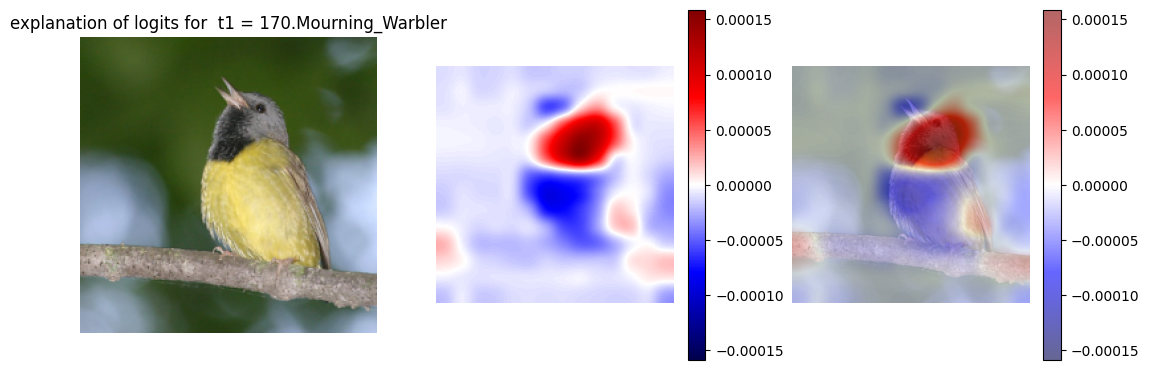

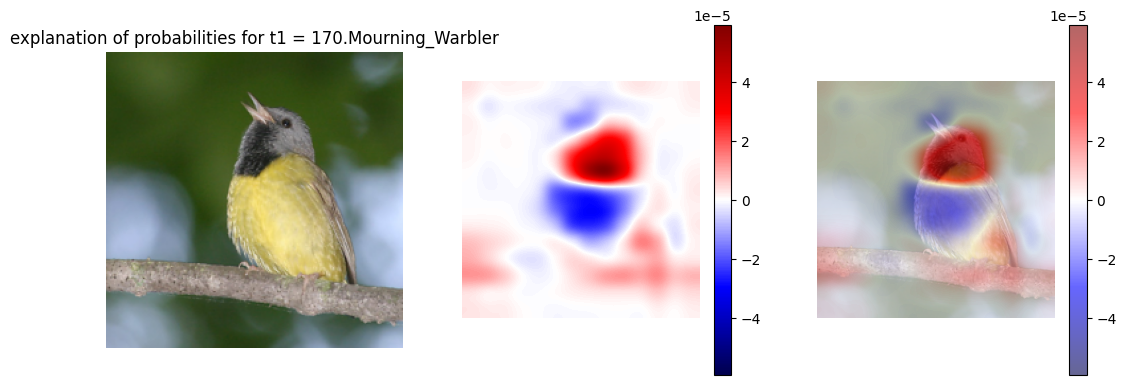

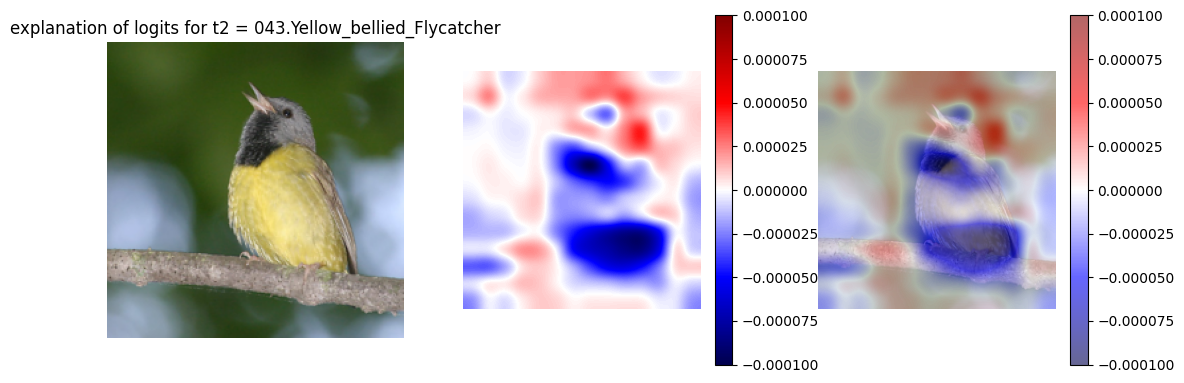

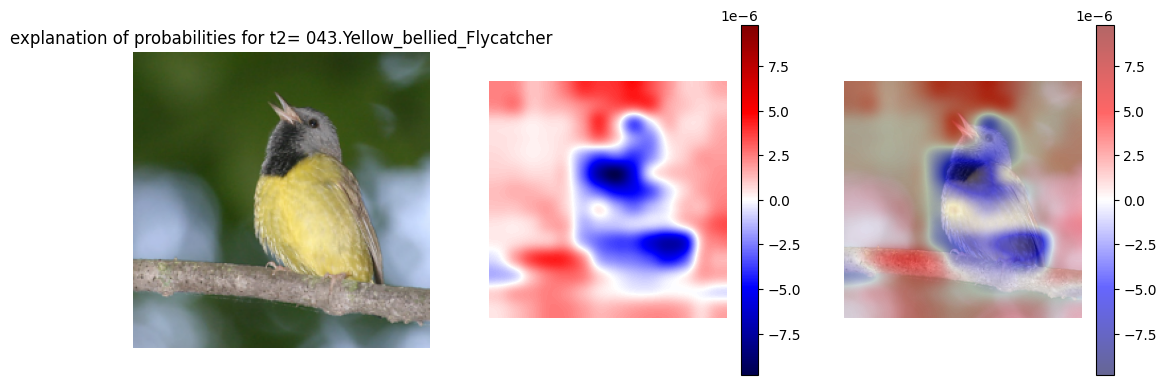

1103024128
1103024128
1103024128


In [ ]:
# Code to get some nice plots.
# Check that the code is working correctly and print some illustrative examples
data_str = 'cub200'
model = None
model = Vgg16_gradcam(data_str = data_str, num_classes=num_classes)
model = model.to(device)
model.eval()

for idx, val_data in enumerate(val_dataloader):
  if idx < 10:
    continue
  val_inputs, val_labels = val_data
  val_inputs = val_inputs.to(device)
  val_labels = val_labels.to(device)
  val_outputs = model(val_inputs)
  val_probs = torch.nn.Softmax(dim=1)(val_outputs)
  _, val_preds = torch.max(val_outputs, 1)
  val_probs_sorted = torch.argsort(val_probs, 1, descending=True)

  val_probs_sorted = val_probs_sorted.squeeze()
  val_probs = val_probs.squeeze()

  print('label: {}, pred: {}'.format(val_labels[0], val_preds[0]))
  print('label: {}, pred: {}'.format(class_names[val_labels[0]], class_names[val_preds[0]]))
  print('most likely label: {}, with probability: {:.3f}'.format(class_names[val_probs_sorted[0]],
                                                             val_probs[val_probs_sorted[0]]))
  print('seconds most likely label: {}, with probability: {:.3f}'.format(class_names[val_probs_sorted[1]],
                                                                     val_probs[val_probs_sorted[1]]))

  pred = val_outputs.argmax(dim=1)

  # heatmap_log = gradcam_logits(model, val_inputs, val_outputs, label=pred, retain_graph=True)
  # heatmap_prob = gradcam_prob(model, val_inputs, val_outputs, label=pred, retain_graph=False)

  heatmap_LA_log_t1 = LA_logits(label=pred, retain_graph=True)

  heatmap_log_t1 = gradcam_logits(label=pred, retain_graph=True)
  heatmap_log_t2 = gradcam_logits(label=val_probs_sorted[1], retain_graph=True)
  heatmap_prob_t1 = gradcam_prob(label=pred, retain_graph=True)
  heatmap_prob_t2 = gradcam_prob(label=val_probs_sorted[1], retain_graph=False)

  plot_heatmaps(heatmap_log_t1, val_inputs, input_size, title='explanation of logits for  t1 = ' +
                class_names[pred])
  plot_heatmaps(heatmap_prob_t1, val_inputs, input_size, title='explanation of probabilities for t1 = ' +
                class_names[pred])
  plot_heatmaps(heatmap_log_t2, val_inputs, input_size, title='explanation of logits for t2 = ' +
                class_names[val_probs_sorted[1]])
  plot_heatmaps(heatmap_prob_t2, val_inputs, input_size, title='explanation of probabilities for t2= ' +
                class_names[val_probs_sorted[1]])



  print(torch.cuda.memory_allocated())
  del val_inputs, val_labels, val_outputs, val_preds, val_probs_sorted, pred, val_probs
  torch.cuda.empty_cache(), 13
  print(torch.cuda.memory_allocated())
  break


del model
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

In [ ]:
def gaussian_blur_features(val_inputs, heatmap, pos=True, plot=False):
  # heatmap 224 x 224
  # val_inputs 1 x 3 x 224 x 224
  # log = ori.
  # prob = wtd.
  inv_val_inputs = invTrans(val_inputs).clone()
  result = inv_val_inputs.clone()
  g_input = transforms.GaussianBlur(kernel_size=19, sigma=(10,10))(inv_val_inputs)
  for c in range(3):
    g_input_channel = g_input[0][c]
    for i in range(np.shape(val_inputs)[2]):
      for j in range(np.shape(val_inputs)[3]):
        # pos == True, apply gauss to pixels with heatmap < 0
        # pos == False, apply gauss to pixels with heatmap >0
        if pos == (heatmap[i][j] < 0):
          result[0][c][i][j] = g_input_channel[i][j]
  if plot:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))
    ax1.imshow(to_pil_image(inv_val_inputs[0], mode='RGB'))
    ax2.imshow(to_pil_image(result[0], mode='RGB'))
    range_nmb = max(abs(heatmap.min()), abs(heatmap.max()))
    norm = TwoSlopeNorm(vmin=-range_nmb,vcenter=0, vmax=range_nmb)
    ax3.imshow(heatmap, alpha=1, norm=norm, cmap='seismic')
    plt.show()

  del inv_val_inputs, g_input, g_input_channel
  torch.cuda.empty_cache()

  return NormalTrans(result)

def zeros_features(val_inputs, heatmap, pos=True, plot=False):
  inv_val_inputs = invTrans(val_inputs)
  result = inv_val_inputs.clone()
  for c in range(3):
    for i in range(np.shape(heatmap)[0]):
      for j in range(np.shape(heatmap)[1]):
        # pos == True, apply gauss to pixels with heatmap < 0
        # pos == False, apply gauss to pixels with heatmap >0
        if pos == (heatmap[i][j] < 0):
          result[0][c][i][j] = 0
  if plot:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))
    ax1.imshow(to_pil_image(inv_val_inputs[0], mode='RGB'))
    ax2.imshow(to_pil_image(result[0], mode='RGB'))
    ax3.imshow(heatmap, cmap='seismic')
    plt.show()

  del inv_val_inputs
  torch.cuda.empty_cache()
  return NormalTrans(result)

def channel_wise_mean_features(val_inputs, heatmap, pos=True, plot=False):
  inv_val_inputs = invTrans(val_inputs)
  result = inv_val_inputs.clone()
  for c in range(3):
    # channel wise mean, cwm
    cwm = torch.mean(val_inputs[0][c])
    for i in range(np.shape(heatmap)[0]):
      for j in range(np.shape(heatmap)[1]):
        # pos == True, apply gauss to pixels with heatmap < 0
        # pos == False, apply gauss to pixels with heatmap >0
        if pos == (heatmap[i][j] < 0):
          result[0][c][i][j] = cwm
  if plot:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))
    ax1.imshow(to_pil_image(inv_val_inputs[0], mode='RGB'))
    ax2.imshow(to_pil_image(result[0], mode='RGB'))
    ax3.imshow(heatmap, cmap='seismic')
    plt.show()
  del inv_val_inputs, cwm
  torch.cuda.empty_cache()
  return NormalTrans(result)

In [ ]:
# Test and plot the different heatmap filters
heatmap = gaussian_filter(np.random.rand(224,224)-0.5,sigma=2)
heatmap = gaussian_filter(heatmap, sigma=4)
heatmap = torch.Tensor(heatmap)
gaussian_blur_features(val_inputs, heatmap, pos=True, plot=True)
gaussian_blur_features(val_inputs, heatmap, pos=False, plot=True)
channel_wise_mean_features(val_inputs, heatmap, pos=True, plot=True)
channel_wise_mean_features(val_inputs, heatmap, pos=False, plot=True)
zeros_features(val_inputs, heatmap, pos=True, plot=True)
zeros_features(val_inputs, heatmap, pos=False, plot=True)




In [ ]:
def run_experiment(exp, label_str, feature, blurtype, exp_type):
  if label_str == 't1':
    label_int = val_probs_sorted[0]
  elif label_str == 't2':
    label_int = val_probs_sorted[1]

  if exp == 'GC':
    if exp_type == 'ori':
      heatmap = gradcam_logits(label=label_int, retain_graph=True)
    elif exp_type == 'wtd':
      heatmap = gradcam_prob(label=label_int, retain_graph=True)
  elif exp == 'LA':
    if exp_type == 'ori':
      heatmap = LA_logits(label=label_int, retain_graph=True)
    elif exp_type == 'wtd':
      heatmap = LA_prob(label=label_int, retain_graph=True)

  if feature == 'pos':
    pos = True
  elif feature == 'neg':
    pos = False

  # ### TEMP
  # plot_heatmaps(heatmap, val_inputs, input_size, title='')
  # ###

  # Report does Bilinear not Bicubic
  overlay = to_pil_image(heatmap.detach(), mode='F').resize((input_size, input_size), resample=PIL.Image.BICUBIC)
  heatmap = np.asarray(overlay)

  if blurtype == 'gauss':
    blurred_inputs = gaussian_blur_features(val_inputs, heatmap, pos=pos, plot=False)
  elif blurtype == 'zeros':
    blurred_inputs = zeros_features(val_inputs, heatmap, pos=pos, plot=False)
  elif blurtype == 'mean':
    blurred_inputs = channel_wise_mean_features(val_inputs, heatmap, pos=pos, plot=False)

  del label_int, heatmap, overlay
  torch.cuda.empty_cache()

  return blurred_inputs

In [ ]:
explainers = ['GC', 'LA']
labels = ['t1', 't2']
features = ['pos', 'neg']
blurtypes = ['gauss', 'zeros', 'mean']
exp_types = ['ori', 'wtd']
counter = 0
experiment_string_list = ['pbar1', 'pbar2']
for exp in explainers:
  for label_str in labels:
    for feature in features:
      for blurtype in blurtypes:
        for exp_type in exp_types:
          experiment_string = '_'.join([exp, label_str, feature, blurtype, exp_type])
          experiment_string_list.append(experiment_string)

In [ ]:
# when performing on cub_200
target_name = 'cub200/'

In [ ]:
# Perform experiment for table 1

data_str = 'cub200'
model = None
model = Vgg16_gradcam(data_str = data_str, num_classes=num_classes)
model = model.to(device)
model.eval()

result_df = pd.DataFrame(columns=experiment_string_list, index=range(len(val_dataloader)))

# run the experiments for
# idx in range(len(val_dataloader))
# 0-101
# 102 - 203
# 204 - 305
# 306 - 407
# 408 - 509
# eventuelly

counter = 0

idx_low = 160
idx_high = 179

for idx_exp, val_data in enumerate(val_dataloader):
  if idx_exp < idx_low:
    # the lowest idx that should be calculated
    continue
  if idx_exp == idx_high+1:
    # one above the largest idx that should be calculated
    break
  print(idx_exp)
  # Calculate outputs of fine_tuned network
  val_inputs, val_labels = val_data

  val_inputs = val_inputs.to(device)
  val_labels = val_labels.to(device)
  val_outputs = model(val_inputs)
  val_probs = torch.nn.Softmax(dim=1)(val_outputs)
  _, val_preds = torch.max(val_outputs, 1)
  val_probs_sorted = torch.argsort(val_probs, 1, descending=True).squeeze()
  val_probs = val_probs.squeeze()
  val_outputs_sorted = torch.argsort(val_outputs, 1, descending=True).squeeze()
  val_outputs_sq = val_outputs.clone().squeeze()

  # Such that the t_1 class is not too dominant
  if val_probs[val_probs_sorted[1]]<0.1:
    continue
  counter += 1

  # print(val_outputs)
  # print('val_outputs_sorted[0]: {}, val_outputs_sq[val_outputs_sorted[0]]: {}'.format(val_outputs_sorted[0], val_outputs_sq[val_outputs_sorted[0]]))
  # print('val_outputs_sorted[1]: {}, val_outputs_sq[val_outputs_sorted[1]]: {}'.format(val_outputs_sorted[1], val_outputs_sq[val_outputs_sorted[1]]))

  y1 = val_outputs_sq[val_outputs_sorted[0]]
  y2 = val_outputs_sq[val_outputs_sorted[1]]

  pbar_1 = torch.exp(y1)/(torch.exp(y1)+torch.exp(y2))
  pbar_2 = torch.exp(y2)/(torch.exp(y1)+torch.exp(y2))

  result_df.at[idx_exp, 'pbar1'] = float(pbar_1.cpu())
  result_df.at[idx_exp, 'pbar2'] = float(pbar_2.cpu())


  for exp in explainers:
    # if exp != 'GC':
    #   continue
    for label_str in labels:
      for feature in features:
        for blurtype in blurtypes:
          # # 'gauss', 'zeros', 'mean'
          # if blurtype != 'zeros':
          #     continue
          for exp_type in exp_types:
            # if exp_type != 'wtd':
            #   continue
            experiment_string = '_'.join([exp, label_str, feature, blurtype, exp_type])

            print(str(idx_exp) + ', ' + experiment_string)

            blurred_inputs = run_experiment(exp, label_str, feature, blurtype, exp_type)
            blurred_outputs = model(blurred_inputs)

            # blurred_outputs_sorted = torch.argsort(blurred_outputs, 1, descending=True).squeeze()
            # blurred_probs = torch.nn.Softmax(dim=1)(blurred_outputs)
            # blurred_probs_sorted = torch.argsort(blurred_probs, 1, descending=True).squeeze()
            # print('v_p_s[0]_ {}, v_p_s[1]: {}'.format(val_probs_sorted[0], val_probs_sorted[1]))
            # print('b_p_s[0]_ {}, b_p_s[1]: {}'.format(blurred_probs_sorted[0], blurred_probs_sorted[1]))

            if label_str == 't1':
              label_int = val_probs_sorted[0]
            elif label_str == 't2':
              label_int = val_probs_sorted[1]

            blurred_y = blurred_outputs[0][label_int]
            # # Old
            # blurred_p = torch.exp(blurred_y)/(torch.exp(y1)+torch.exp(y2))

            # new
            blurred_p = torch.exp(blurred_y)/(torch.exp(blurred_outputs[0][val_probs_sorted[0]]) + torch.exp(blurred_outputs[0][val_probs_sorted[1]]))


            result_df.at[idx_exp, experiment_string] = float(blurred_p.cpu())
            # print('y1: {}, y2: {}, pbar1: {}, pbar2: {}'.format(y1, y2, pbar_1, pbar_2))
            # print('blurred_y: {}, blurred_p: {}'.format(blurred_y, blurred_p))

            # print('pbar1: {}, pbar2: {}'.format(pbar_1, pbar_2))
            # asdfghjk = torch.exp(blurred_outputs[0][val_probs_sorted[0]]) + torch.exp(blurred_outputs[0][val_probs_sorted[1]])
            # print('blurred_p1: {}, blurred_p2: {}'.format(torch.exp(blurred_outputs[0][val_probs_sorted[0]])/asdfghjk, torch.exp(blurred_outputs[0][val_probs_sorted[1]])/asdfghjk))
            # print('blurred_p: {}'.format(blurred_p))
            # print('\n')

            del blurred_y, blurred_p, blurred_inputs, blurred_outputs, label_int
            # del blurred_outputs_sorted, blurred_probs, blurred_probs_sorted
            # del asdfghjk
            torch.cuda.empty_cache()


  print(torch.cuda.memory_allocated())
  del val_inputs, val_labels, val_outputs, val_preds, val_probs_sorted, val_probs, val_outputs_sorted, val_outputs_sq
  del y1, y2, pbar_1, pbar_2
  torch.cuda.empty_cache()
  print(torch.cuda.memory_allocated())

print('counter: {}'.format(counter))

target_directory = './table1/'

# Create the target directory if it doesn't exist
if not os.path.exists(target_directory + target_name):
    os.makedirs(target_directory + target_name)

save_str = '_{}_{}'.format(idx_low, idx_high)

result_df.to_csv(target_directory + target_name +  'result_df' + str(save_str) + '.csv')
result_df.to_csv('./drive/MyDrive/DD2412/table1/' + target_name + 'result_df' + str(save_str) + '.csv')
## TEMPORARLY COMMENTED OUT
del model
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
## TEMP

160
160, GC_t1_pos_gauss_ori
160, GC_t1_pos_gauss_wtd
160, GC_t1_pos_zeros_ori
160, GC_t1_pos_zeros_wtd
160, GC_t1_pos_mean_ori
160, GC_t1_pos_mean_wtd
160, GC_t1_neg_gauss_ori
160, GC_t1_neg_gauss_wtd
160, GC_t1_neg_zeros_ori
160, GC_t1_neg_zeros_wtd
160, GC_t1_neg_mean_ori
160, GC_t1_neg_mean_wtd
160, GC_t2_pos_gauss_ori
160, GC_t2_pos_gauss_wtd
160, GC_t2_pos_zeros_ori
160, GC_t2_pos_zeros_wtd
160, GC_t2_pos_mean_ori
160, GC_t2_pos_mean_wtd
160, GC_t2_neg_gauss_ori
160, GC_t2_neg_gauss_wtd
160, GC_t2_neg_zeros_ori
160, GC_t2_neg_zeros_wtd
160, GC_t2_neg_mean_ori
160, GC_t2_neg_mean_wtd
160, LA_t1_pos_gauss_ori
160, LA_t1_pos_gauss_wtd
160, LA_t1_pos_zeros_ori
160, LA_t1_pos_zeros_wtd
160, LA_t1_pos_mean_ori
160, LA_t1_pos_mean_wtd
160, LA_t1_neg_gauss_ori
160, LA_t1_neg_gauss_wtd
160, LA_t1_neg_zeros_ori
160, LA_t1_neg_zeros_wtd
160, LA_t1_neg_mean_ori
160, LA_t1_neg_mean_wtd
160, LA_t2_pos_gauss_ori
160, LA_t2_pos_gauss_wtd
160, LA_t2_pos_zeros_ori
160, LA_t2_pos_zeros_wtd
160, LA_

In [ ]:
# Move files into drive manually
import shutil
move_str = '_240_259'
shutil.copyfile('./table1/' + target_name + 'result_df' + str(move_str) + '.csv', './drive/MyDrive/DD2412/table1/' + target_name + 'result_df' + str(move_str) + '.csv')

'./drive/MyDrive/DD2412/table1/Flowers_102/result_df_240_259.csv'

In [ ]:
# Calculate and print means (and std) for table 1
# Plot the means and std of the results

root_loc_str = './drive/MyDrive/DD2412/table1/'
# dataset_loc_str = 'Flowers_102/'
dataset_loc_str = 'cub200/'
result_df = pd.DataFrame(columns=experiment_string_list, index=range(len(val_dataloader)))
for df_str in os.listdir(root_loc_str + dataset_loc_str):
  if df_str == '.ipynb_checkpoints':
    continue
  print(df_str)
  split_list = df_str.split('_')
  idx1 = int(split_list[2])
  idx2, _ = split_list[3].split('.')
  idx2 = int(idx2)
  print('idx1: {}, idx2: {}'.format(idx1, idx2))
  result_df_load = pd.read_csv(root_loc_str + dataset_loc_str + df_str)
  # print(result_df_load.loc[idx1:idx2,:])
  result_df.loc[idx1:idx2,:]=result_df_load.loc[idx1:idx2,:]

result_df_0_9.csv
idx1: 0, idx2: 9
result_df_10_19.csv
idx1: 10, idx2: 19
result_df_20_29.csv
idx1: 20, idx2: 29
result_df_30_39.csv
idx1: 30, idx2: 39
result_df_40_49.csv
idx1: 40, idx2: 49
result_df_50_69.csv
idx1: 50, idx2: 69
result_df_70_89.csv
idx1: 70, idx2: 89
result_df_90_109.csv
idx1: 90, idx2: 109
result_df_110_129.csv
idx1: 110, idx2: 129
result_df_130_139.csv
idx1: 130, idx2: 139


In [ ]:
# Calculate and print means (and std) for table 1, Part 2
target_directory_load = './table1/'
# target_name_load = 'Flowers_102/'
target_name_load = 'cub200/'
if not os.path.exists(target_directory_load + target_name_load):
    os.makedirs(target_directory_load + target_name_load)
result_df.to_csv(target_directory_load + target_name_load +  'result_df' + '_temp' + '.csv')

def blank_fill(ele_str, length):
    res_str = ele_str
    while len(res_str) < length:
        res_str = res_str + ' '
    return res_str

print(experiment_string_list)

max_len = -1
for exp_str in experiment_string_list:
    if len(exp_str) > max_len:
        max_len = len(exp_str)
        res_str = exp_str

experiment_string_list_custom = []
# 'pbar1', 'pbar2'
for exp in ['LA', 'GC']:
  for label in labels:
    if label == 't1':
      experiment_string_list_custom.append('pbar1')
    else:
      experiment_string_list_custom.append('pbar2')
    for blurtype in blurtypes:
      for feature in features:
        for exp_type in exp_types:
          experiment_string = '_'.join([exp, label, feature, blurtype, exp_type])
          experiment_string_list_custom.append(experiment_string)

print(len(experiment_string_list_custom))
print(experiment_string_list_custom[:13])
print(experiment_string_list_custom[13:26])
print(experiment_string_list_custom[26:39])
print(experiment_string_list_custom[39:])

print(result_df.loc[:,'pbar1'].mean())
# mean_list = [result_df.loc[:, exp_str].mean() for exp_str in experiment_string_list_custom]
# print(result_df.dropna())
mean_list = [result_df.dropna().loc[:, exp_str].mean() for exp_str in experiment_string_list_custom]
testlist = [1.23456, 2.00000]
print('{0[0]:.3f}, {0[1]:.3f}'.format(testlist))

print('   |    |     |     Gaussian Blur     |         Zeros         |   Channel-wise Mean   |')
print('   |    | pt  |pos.  ft.  |neg.  ft.  |pos.  ft.  |neg.  ft.  |pos.  ft.  |neg.  ft.  |')
print('   |    |     |ori. |wtd. |ori. |wtd. |ori. |wtd. |ori. |wtd. |ori. |wtd. |ori. |wtd. |')
print('--------------------------------------------------------------------------')
print('LA | t1 |{0[0]:.3f}|{0[1]:.3f}|{0[2]:.3f}|{0[3]:.3f}|{0[4]:.3f}|{0[5]:.3f}|{0[6]:.3f}|{0[7]:.3f}|{0[8]:.3f}|{0[9]:.3f}|{0[10]:.3f}|{0[11]:.3f}|{0[12]:.3f}|'.format(mean_list[:13]))
print('   | t2 |{0[0]:.3f}|{0[1]:.3f}|{0[2]:.3f}|{0[3]:.3f}|{0[4]:.3f}|{0[5]:.3f}|{0[6]:.3f}|{0[7]:.3f}|{0[8]:.3f}|{0[9]:.3f}|{0[10]:.3f}|{0[11]:.3f}|{0[12]:.3f}|'.format(mean_list[13:26]))
print('GC | t1 |{0[0]:.3f}|{0[1]:.3f}|{0[2]:.3f}|{0[3]:.3f}|{0[4]:.3f}|{0[5]:.3f}|{0[6]:.3f}|{0[7]:.3f}|{0[8]:.3f}|{0[9]:.3f}|{0[10]:.3f}|{0[11]:.3f}|{0[12]:.3f}|'.format(mean_list[26:39]))
print('   | t2 |{0[0]:.3f}|{0[1]:.3f}|{0[2]:.3f}|{0[3]:.3f}|{0[4]:.3f}|{0[5]:.3f}|{0[6]:.3f}|{0[7]:.3f}|{0[8]:.3f}|{0[9]:.3f}|{0[10]:.3f}|{0[11]:.3f}|{0[12]:.3f}|'.format(mean_list[39:]))
print('--------------------------------------------------------------------------')

['pbar1', 'pbar2', 'GC_t1_pos_gauss_ori', 'GC_t1_pos_gauss_wtd', 'GC_t1_pos_zeros_ori', 'GC_t1_pos_zeros_wtd', 'GC_t1_pos_mean_ori', 'GC_t1_pos_mean_wtd', 'GC_t1_neg_gauss_ori', 'GC_t1_neg_gauss_wtd', 'GC_t1_neg_zeros_ori', 'GC_t1_neg_zeros_wtd', 'GC_t1_neg_mean_ori', 'GC_t1_neg_mean_wtd', 'GC_t2_pos_gauss_ori', 'GC_t2_pos_gauss_wtd', 'GC_t2_pos_zeros_ori', 'GC_t2_pos_zeros_wtd', 'GC_t2_pos_mean_ori', 'GC_t2_pos_mean_wtd', 'GC_t2_neg_gauss_ori', 'GC_t2_neg_gauss_wtd', 'GC_t2_neg_zeros_ori', 'GC_t2_neg_zeros_wtd', 'GC_t2_neg_mean_ori', 'GC_t2_neg_mean_wtd', 'LA_t1_pos_gauss_ori', 'LA_t1_pos_gauss_wtd', 'LA_t1_pos_zeros_ori', 'LA_t1_pos_zeros_wtd', 'LA_t1_pos_mean_ori', 'LA_t1_pos_mean_wtd', 'LA_t1_neg_gauss_ori', 'LA_t1_neg_gauss_wtd', 'LA_t1_neg_zeros_ori', 'LA_t1_neg_zeros_wtd', 'LA_t1_neg_mean_ori', 'LA_t1_neg_mean_wtd', 'LA_t2_pos_gauss_ori', 'LA_t2_pos_gauss_wtd', 'LA_t2_pos_zeros_ori', 'LA_t2_pos_zeros_wtd', 'LA_t2_pos_mean_ori', 'LA_t2_pos_mean_wtd', 'LA_t2_neg_gauss_ori', 'LA_t2